In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale

plt.style.use(['seaborn-notebook', 'seaborn-white', 'seaborn-ticks'])

import mlgrad.func as func
import mlgrad.avragg as avragg
import mlgrad.mlocation_scatter2 as mlocation_scatter

from mlgrad import averager_it

In [2]:
import matplotlib as mpl

In [3]:
mpl.rcParams['figure.autolayout'] = True
#mpl.rcParams

In [4]:
def permutate_values(Yp, Y, m):
    d = {}
    for yp,y in zip(Yp, Y):
        c = d.setdefault((yp,y), 0)
        d[(yp,y)] = c+1
    print(d)
    values = np.array(list(d.values()))
    keys = list(d.keys())
    indices = list(np.argsort(values))
    keys = [keys[indices[-i]] for i in range(1,m+1)]
    print(keys)
    d = dict(keys)
    for i in range(len(Y)):
        yp = Yp[i]
        Yp[i] = d[yp]

In [5]:
sdata = pd.read_csv("data/cbb/s4.txt", names=['x1', 'x2'], sep='\s+')

In [6]:
X = np.c_[sdata['x1'], sdata['x2']]
X = np.ascontiguousarray(X, 'd')
X = scale(X)
print(len(X))
print(X)

5000
[[ 0.72905927  1.96205575]
 [ 1.0227693   1.37289377]
 [ 0.86690577  1.03658706]
 ...
 [ 0.39771873  1.39031359]
 [-0.35056426  2.19961753]
 [-0.41385794  1.82872473]]


In [7]:
xrange1 = np.linspace(0., 2., 100)
xrange2 = np.linspace(0., 2., 100)
XX1, XX2, = np.meshgrid(xrange1, xrange2)
XX = np.c_[XX1.ravel(), XX2.ravel()]

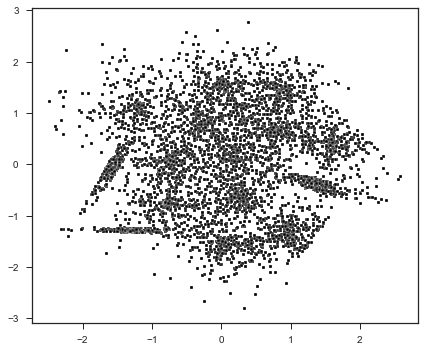

In [8]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
plt.show()

In [9]:
avrfunc = averager_it(func.QuantileFunc(0.97, func.Sqrt(0.001)))
avrfunc = avragg.MHAverage(avrfunc)
hcd = mlocation_scatter.MLocationsScattersEstimator(avrfunc, 15, 
                                    tol=1.0e-8, n_iter=1000, n_step=22, h=0.95)

In [10]:
hcd.fit(X)

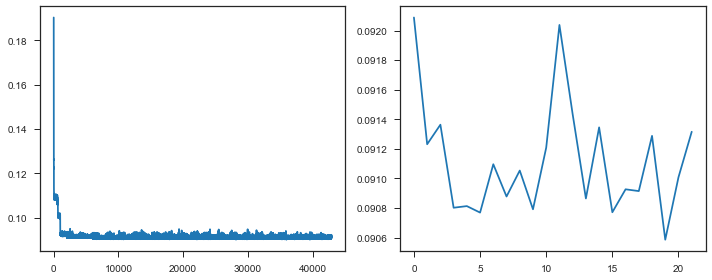

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hcd.dvals)
plt.subplot(1,2,2)
plt.plot(hcd.dvals2)
plt.show()

In [12]:
xrange1 = np.linspace(-3, 3, 100)
xrange2 = np.linspace(-3, 3, 100)
XX1, XX2, = np.meshgrid(xrange1, xrange2)
XX = np.c_[XX1.ravel(), XX2.ravel()]
D = hcd.evaluate_dist(XX)
# C = hcd.evaluate(XX)
# CC = np.asarray(C).reshape(XX1.shape)
DD = D.reshape(XX1.shape)
print(D.min(), D.max())

4.240367405984094e-05 9.542554410262587


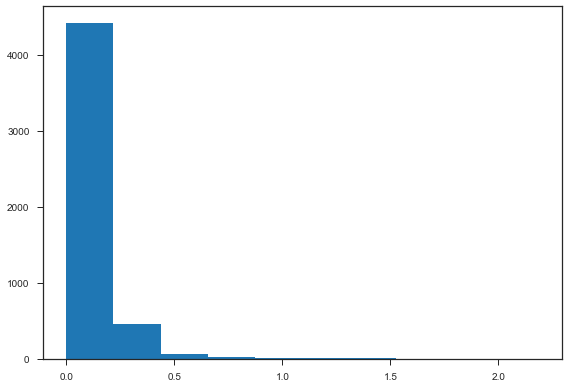

In [13]:
DX = hcd.evaluate_dist(X)
plt.hist(DX)
plt.show()

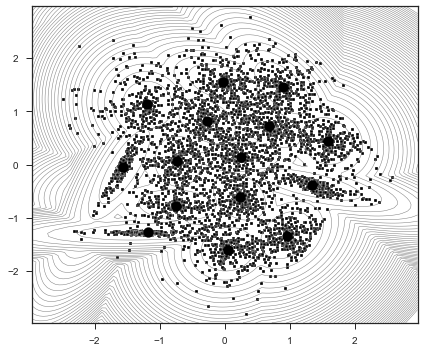

In [14]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
plt.contour(DD, origin='lower', extent=(-3,3,-3,3), 
            levels=np.linspace(0.0,8.5,50), colors='grey', linewidths=0.5)
plt.scatter(hcd.locs[:,0], hcd.locs[:,1], c='k', edgecolors='k', s=100)
plt.show()

### Среднее арифметическое

In [23]:
arith = avragg.ArithMean()
km = mlocation_scatter.MLocationsScattersEstimator(arith, 15, 
                                    tol=1.0e-8, n_iter=500, n_step=22, h=0.95)

In [24]:
km.fit(X)

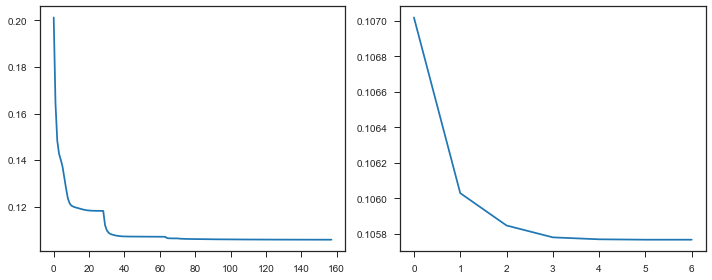

In [25]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(km.dvals)
plt.subplot(1,2,2)
plt.plot(km.dvals2)
plt.show()

In [26]:
D2 = km.evaluate_dist(XX)
DD2 = D2.reshape(XX1.shape)
print(D2.min(), D2.max())

9.289559761093963e-06 8.988456042619731


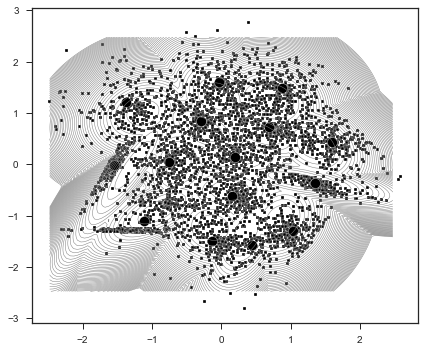

In [27]:
plt.figure(figsize=(6,5))
plt.contour(DD2, origin='lower', extent=(-2.5,2.5,-2.5,2.5), 
            levels=np.linspace(0.,4.,50), colors='grey', linewidths=0.5)
plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
plt.scatter(km.locs[:,0], km.locs[:,1], c='k', edgecolors='w', s=100)
plt.show()

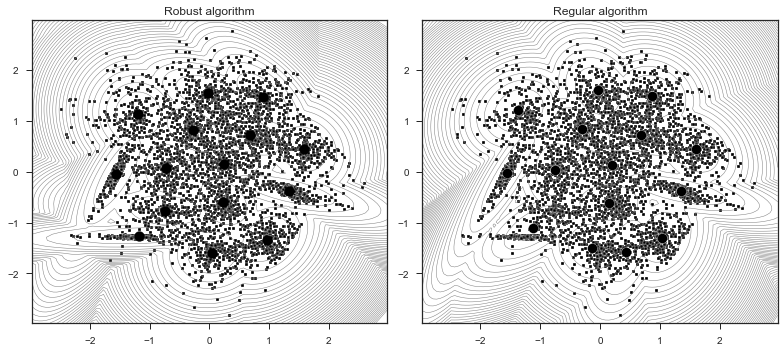

In [28]:
plt.figure(figsize=(11,5))

plt.subplot(1,2,1)
plt.title('Robust algorithm')
plt.contour(DD, origin='lower', extent=(-3.,3.,-3.,3.), 
            levels=np.linspace(0.,8.5,50), colors='grey', linewidths=0.5)
plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
plt.scatter(hcd.locs[:,0], hcd.locs[:,1], c='k', edgecolors='k', s=100)

plt.subplot(1,2,2)
plt.title('Regular algorithm')
plt.contour(DD2, origin='lower', extent=(-3.,3.,-3.,3.0), 
            levels=np.linspace(0.,8.5,50), colors='grey', linewidths=0.5)
plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
plt.scatter(km.locs[:,0], km.locs[:,1], c='k', edgecolors='w', s=100)
plt.savefig('fig/robust_kmeans_center_variance_s4.eps')
plt.tight_layout()
plt.show()